In [1]:
from getpass import getpass

admin_rdm_url = 'https://admin.bh.rdm.yzwlab.com/' #'https://admin.staging.rdm.example.com/'
idp_name_1 = None # 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
default_result_path = None
close_on_fail = False
transition_timeout = 30000

In [2]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

# 定期監視-管理者-機関設定

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン
- シナリオ名: ログイン確認
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)
- 備考: https://bitbucket.org/osf_japan/operations/src/master/ARI/%E9%81%8B%E7%94%A8%E6%89%8B%E9%A0%86%E6%9B%B8/%E7%9B%A3%E8%A6%96/%E8%BF%BD%E5%8A%A0%E7%9B%A3%E8%A6%96_%E7%AE%A1%E7%90%86%E8%80%85%E7%94%BB%E9%9D%A2%E3%83%AD%E3%82%B0%E3%82%A4%E3%83%B3%E7%A2%BA%E8%AA%8D.md

## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。

③ブラウザを開き、下記URLにアクセスする。  
https://rdm.example.com/  

In [3]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmp7b4zv5t6'

In [27]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20250420-224415', '/tmp/tmpks65adsw')

Start epoch: 1745189055.6001692 seconds


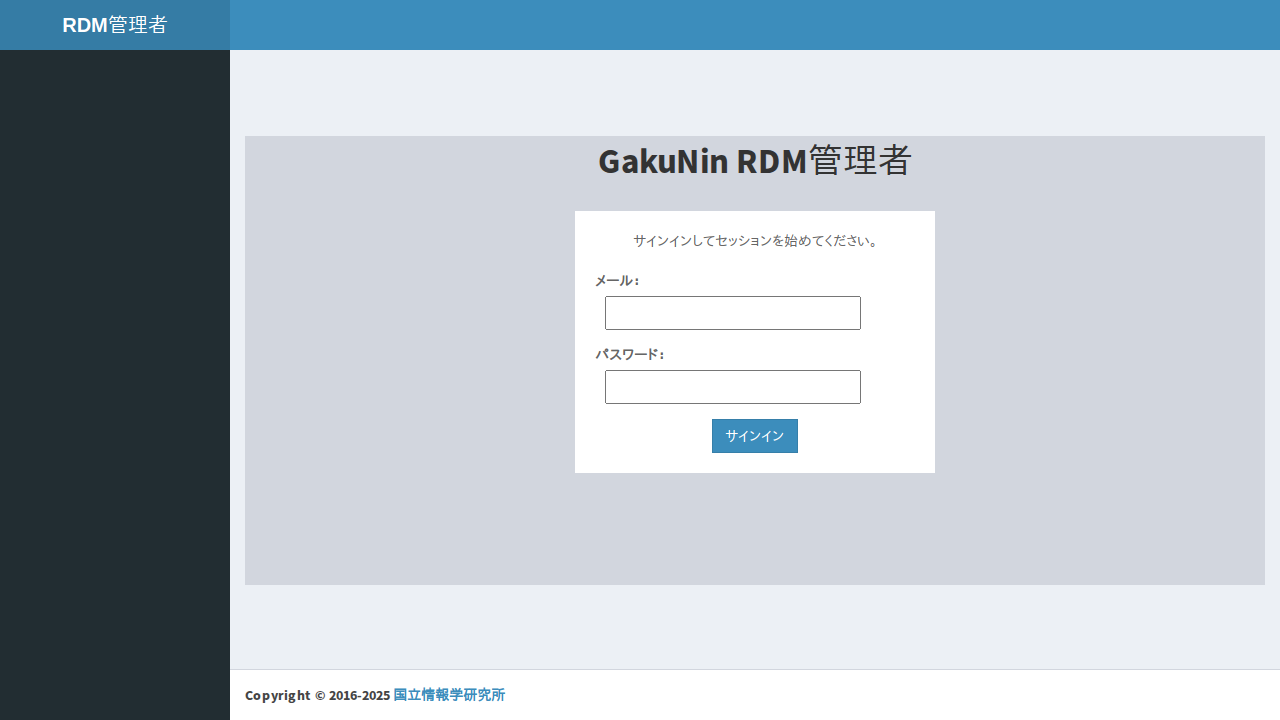

In [28]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1745189056.4448152 seconds


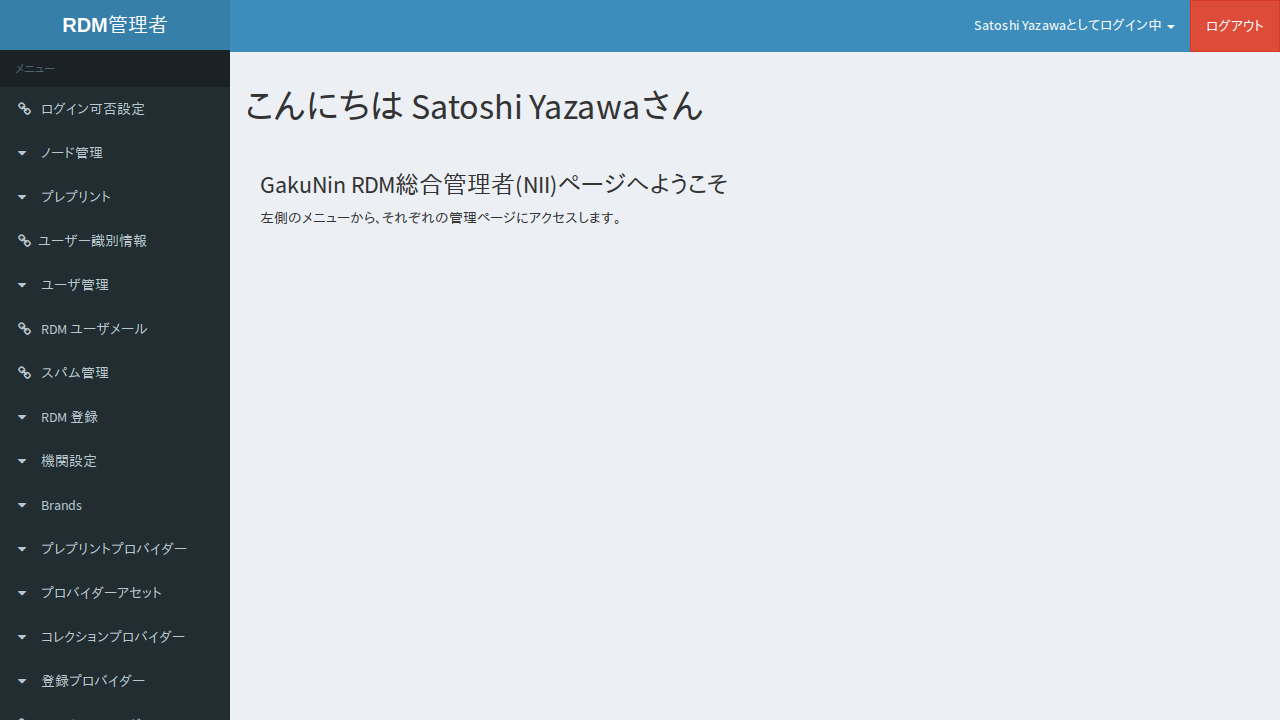

In [29]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login_as_admin(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await expect(page.locator('//*[contains(@class, "btn-danger") and contains(text(), "ログアウト")]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「機関設定」から「リスト」を選択する

「機関のリスト」が表示される

Start epoch: 1745189057.3355749 seconds


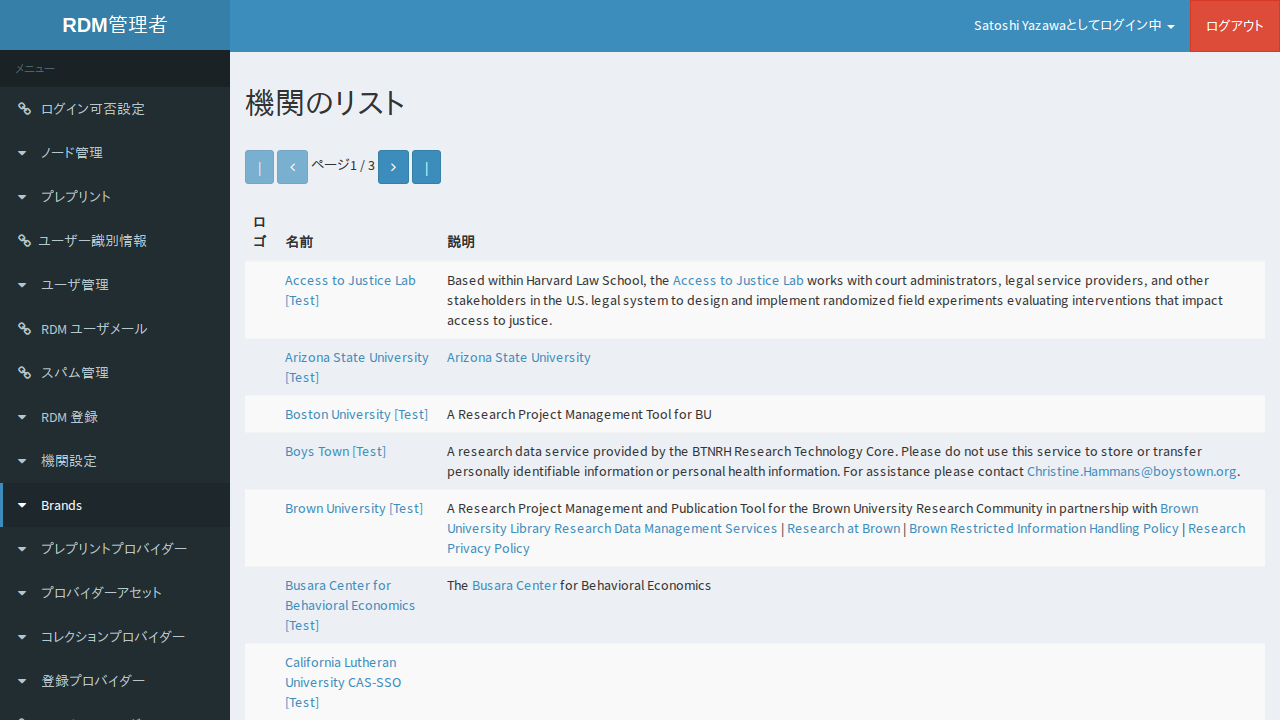

In [30]:
async def _step(page):
    await page.locator('//a[@href = "#collapseInstitutions"]').click()
    await page.locator('//a[@href = "/institutions/"]').click()

    await expect(page.locator('//h2[text() = "機関のリスト"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「機関のリスト」画面の名前から「GakuNin RDM IdP」を選択する

「GakuNin RDM IdP」の詳細が表示される

Start epoch: 1745189057.8431134 seconds


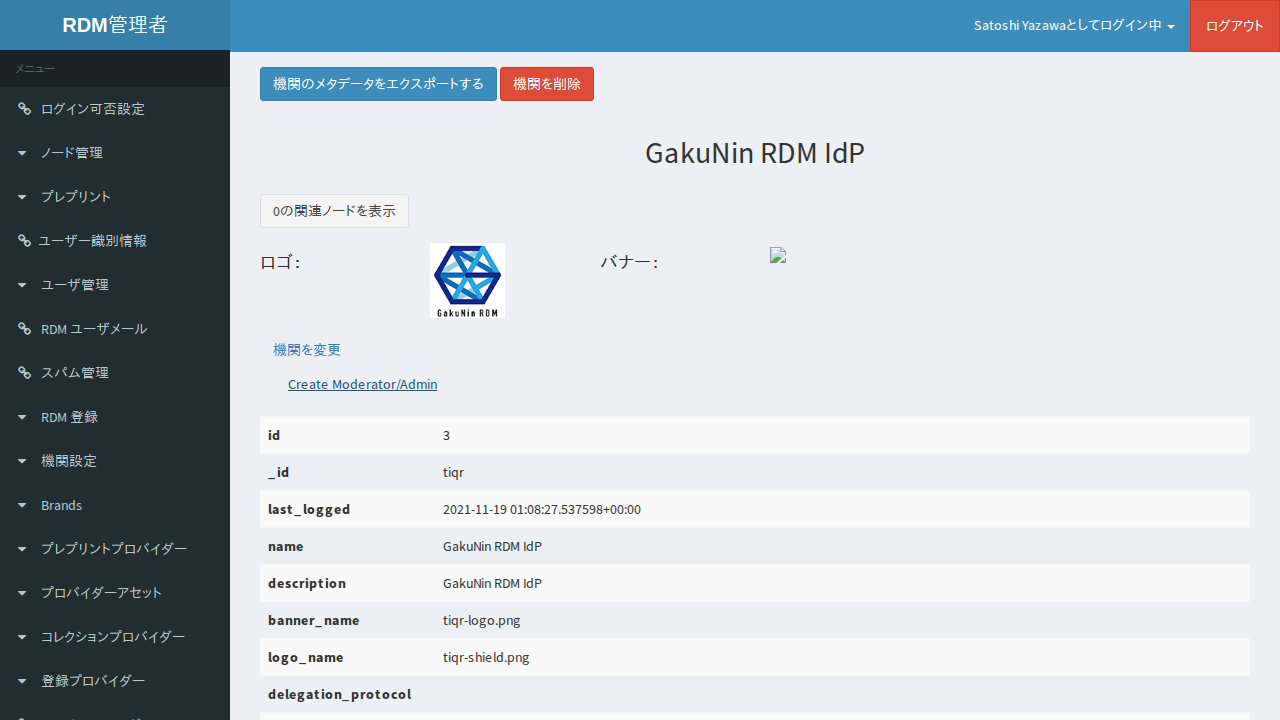

In [31]:
import traceback

target_organization = 'GakuNin RDM IdP'

async def _step(page):
    while True:
        link = page.locator(f'//a[text() = "{target_organization}"]')
        try:
            await expect(link).to_be_visible()
        except:
            traceback.print_exc()
            print('Search next page...')
            # 次のページかもしれない
            await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
            await expect(page.locator('//h2[text() = "機関のリスト"]')).to_be_visible(timeout=transition_timeout)
            continue
        await link.click()
        break

    await expect(page.locator(f'//h2[text() = "{target_organization}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「GakuNin RDM IdP」詳細ページの「機関のメタデータをエクスポートする」ボタンを押下する

「GakuNin RDM IdPのメタデータのエクスポート」がダウンロードされる

Start epoch: 1745189058.2499804 seconds


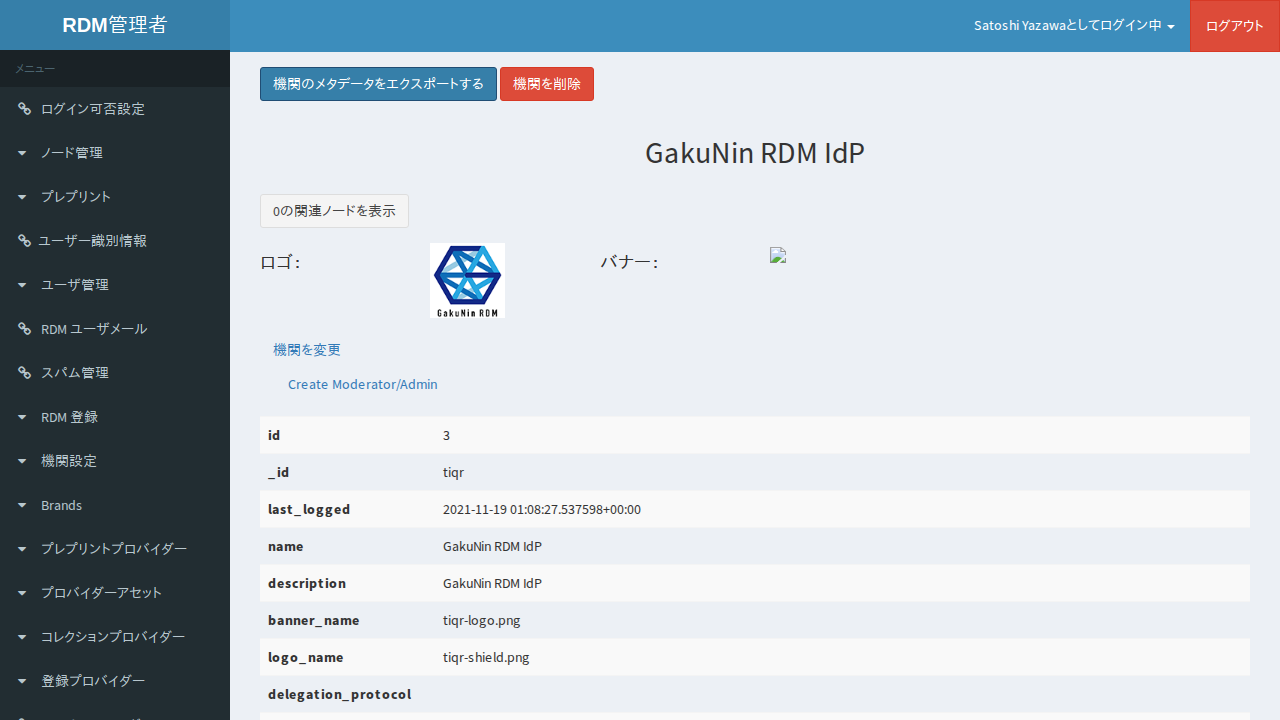

In [32]:
async def _step(page):
    async with page.expect_download(timeout=transition_timeout * 5) as download_info:
        await page.locator('//a[text() = "機関のメタデータをエクスポートする"]').click(timeout=transition_timeout * 5)
    download = await download_info.value
    download_dir = os.path.join(work_dir, 'downloaded')
    os.makedirs(download_dir, exist_ok=True)
    download_path = os.path.join(download_dir, download.suggested_filename)
    await download.save_as(download_path)

await run_pw(_step)

In [33]:
!ls -la {work_dir}/downloaded

total 12
drwxr-xr-x 2 jovyan users 4096 Apr 20 22:40  .
drwx------ 3 jovyan users 4096 Apr 20 22:40  ..
-rw-r--r-- 1 jovyan users  600 Apr 20 22:44 'GakuNin RDM IdP_export.json'


## 「GakuNin RDM IdP」詳細ページの「関連ノードを表示」ボタンを押下する

「GakuNin RDM IdPのノードリスト」が表示される

Start epoch: 1745189058.6696641 seconds


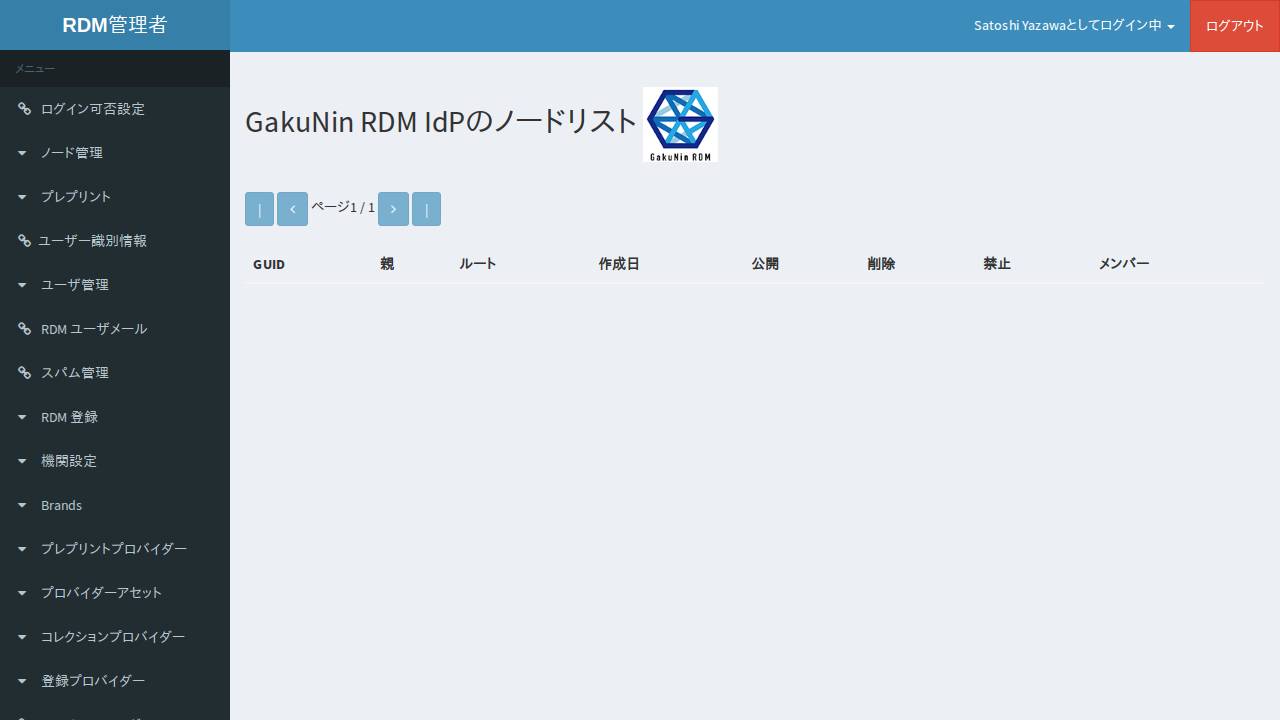

In [34]:
async def _step(page):
    await page.locator('//a[contains(text(), "関連ノードを表示")]').click()
    
    await expect(page.locator(f'//h2[contains(text(), "{target_organization}のノードリスト")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [35]:
await finish_pw_context()

Video: /tmp/tmp7b4zv5t6/video-1.webm
HAR: /tmp/tmp7b4zv5t6/har.zip


In [36]:
!rm -fr {work_dir}